HHU Deep Learning, SS2023/24, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 05 - Image Clustering
---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 23.05.2022 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/ddcsEEk16MvCKE5](https://uni-duesseldorf.sciebo.de/s/ddcsEEk16MvCKE5)

---
# Introduction 

Image clustering in deep learning can be mathematically described as a process of partitioning a set of images, X, into K clusters, where K is a user-defined parameter representing the number of desired clusters.

Let V(X) be the visual feature representation of the images in X, obtained using a deep learning algorithm such as a convolutional neural network (CNN). Each image in X is transformed into a feature vector in V(X), where the dimensions correspond to the learned features of the CNN.

Image clustering is a task in deep learning where an algorithm is used to group similar images together based on their visual characteristics. Ideally, images with similar ground truth labels will belong in the same cluster.

The goal of image clustering is to automatically categorize large sets of images into smaller subsets based on their similarities, which can help in organizing and managing large image datasets.

To accomplish this task, deep learning algorithms use complex mathematical models to analyze and identify patterns within the images, and then group the images that share these patterns into clusters. This process can be useful in a variety of applications, such as image recognition, image search, and content-based image retrieval.


[SimCLR Paper](https://arxiv.org/abs/2002.05709)

[MoCo Paper](https://arxiv.org/abs/1911.05722)

[SCAN Paper](https://arxiv.org/abs/2005.12320v2)




In [1]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week05/utils.py

File ‘utils.py’ already there; not retrieving.




### Imports, basic utils, augmentations

In [1]:
import os
import torch
import torchvision.models as models
import numpy as np

import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim import Adam
import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Local imports
from utils import *


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Task 1: Load the pretrained MoCO model ResNet50 pretrained on ImageNet

[Weights are available in this link](https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar)

You can download the weight by running the terminal command:

`$ wget link_to_model_weights`



In [3]:
# !wget https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar

In [10]:
def load_moco_model(pretrained_path = "./moco_v2_800ep_pretrain.pth.tar"):
    ### START CODE HERE ### (≈ 12 lcheckpoint = torch.load('moco_v2_800ep_pretrain.pth.tar')
    checkpoint = torch.load(pretrained_path)
    checkpoint_dict = checkpoint['state_dict']
    for k in list(checkpoint_dict.keys()):
        if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
            checkpoint_dict[k[len('module.encoder_q.'):]] = checkpoint_dict[k]
        del checkpoint_dict[k]

    model = models.resnet50()
    model.fc = nn.Identity()
    model.load_state_dict(checkpoint_dict)
    ### END CODE HERE ###
    model.eval()
    return model

encoder = load_moco_model()

### Expected results

There should be no missing keys, while loading the model. There may be some unexpected keys based on your implementation.

```python
Loaded model with message: _IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias'])
```

## Task 2: Compute the k-means clustering accuracy using the learned representations


Compute the accuracy both for the train and test split using k-means.

- You can pre-compute the image feature representations
- Use the labelled data of STL10 (train split).
- Hint: you may use the function 'compute_clustering_metrics' defined in `utils.py``


In [44]:
### START CODE HERE ### (>10 lines of code)
# import KMeans from sklearn
from sklearn.cluster import KMeans
# Load the STL10 dataset
transform = T.Compose([
    T.ToTensor(),
])

# Load the STL10 dataset
stl10_train = STL10('./data', split='train', download=False, transform=transform)
stl10_test = STL10('./data', split='test', download=False, transform=transform)

# Create dataloaders
train_loader = DataLoader(stl10_train, batch_size=8, shuffle=False)
test_loader = DataLoader(stl10_test, batch_size=8, shuffle=False)

# Extract train features from the encoder
train_features = []
train_labels = []

for (image, labels) in train_loader:
    features = encoder(image)
    train_features.append(features.detach().numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

# Extract test features from the encoder
test_features = []
test_labels = []

for (image, labels) in test_loader:
    features = encoder(image)
    test_features.append(features.detach().numpy())
    test_labels.append(labels.numpy())

test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

kmeans = KMeans(n_clusters=10, random_state=0).fit(train_features)

print("Train acc: ", compute_clustering_metrics(train_labels, kmeans.labels_,
    min_samples_per_class=100)[0])



kmeans = KMeans(n_clusters=10, random_state=0).fit(test_features)
print("Test acc: ", compute_clustering_metrics(test_labels, kmeans.predict(test_features),
    min_samples_per_class=100)[0])
### END CODE HERE ###

/home/hongli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Train acc:  48.72


/home/hongli/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Test acc:  49.125


### Expected results

`Train acc: 55.86, Val acc: 55.86`

Results may vary due to random initialization!

### Task 3: T-SNE visualization of features

As in the previous exercise, check the results of linear probing on the supervised training split and the T-SNE visualization.

Code for the T-SNE visualization exists in `utils.py`.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 13000 samples in 0.006s...
[t-SNE] Computed neighbors for 13000 samples in 2.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13000
[t-SNE] Computed conditional probabilities for sample 2000 / 13000
[t-SNE] Computed conditional probabilities for sample 3000 / 13000
[t-SNE] Computed conditional probabilities for sample 4000 / 13000
[t-SNE] Computed conditional probabilities for sample 5000 / 13000
[t-SNE] Computed conditional probabilities for sample 6000 / 13000
[t-SNE] Computed conditional probabilities for sample 7000 / 13000
[t-SNE] Computed conditional probabilities for sample 8000 / 13000
[t-SNE] Computed conditional probabilities for sample 9000 / 13000
[t-SNE] Computed conditional probabilities for sample 10000 / 13000
[t-SNE] Computed conditional probabilities for sample 11000 / 13000
[t-SNE] Computed conditional probabilities for sample 12000 / 13000
[t-SNE] Computed conditional probabilities for sa

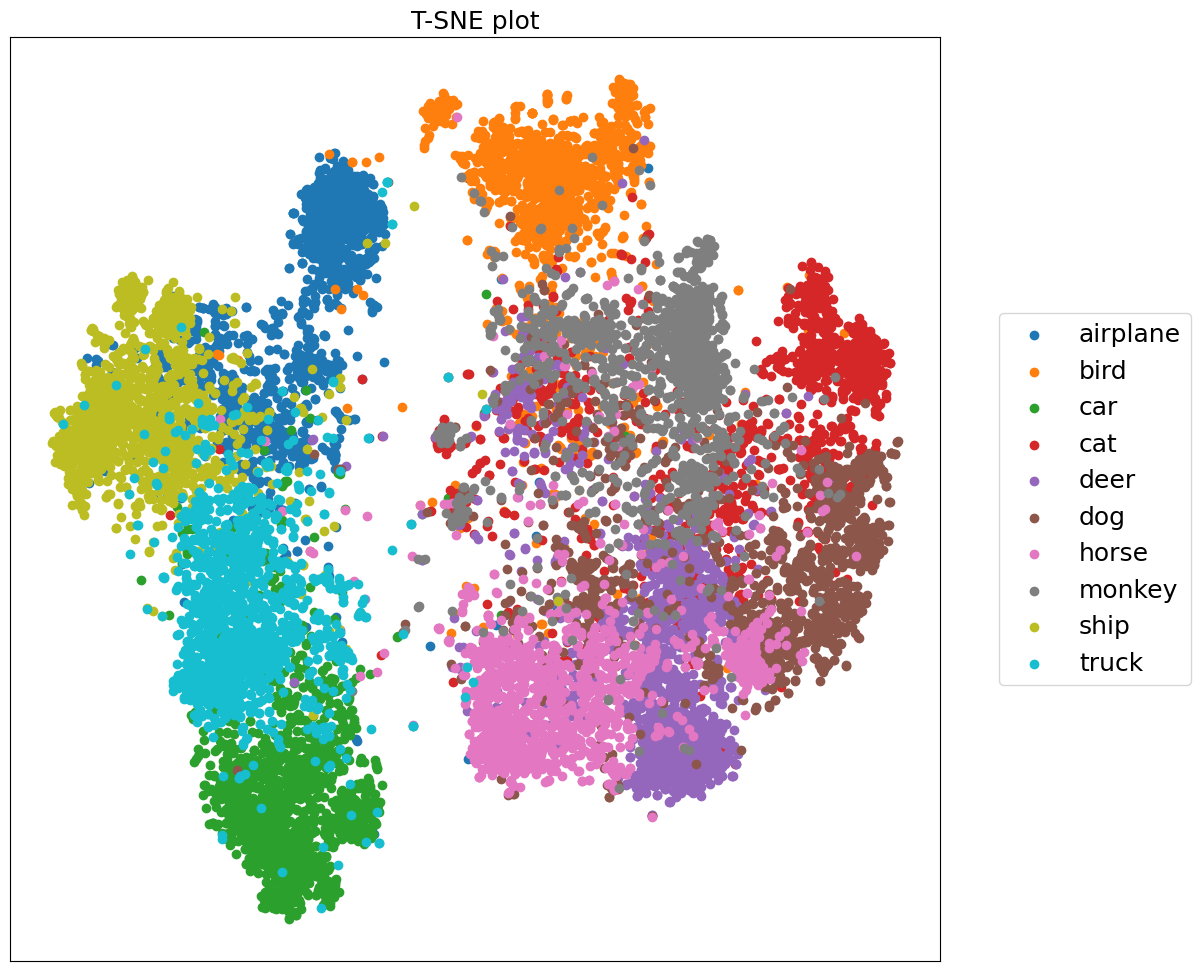

In [50]:
### START CODE HERE ### ( 3 line of code)
class_names = torchvision.datasets.STL10(root='./data').classes
features = torch.from_numpy(np.concatenate([train_features, test_features]))
labels = torch.from_numpy(np.concatenate([train_labels, test_labels]))
tsne_plot_embeddings(features, labels, class_names)
### END CODE HERE ###

## Expected result
![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week05/figs/tsne_plot_embeddings_solution.png)

### Task 4: Compute the k=50 nearset neiboughrs on the feature space of the pretrained ResNet50

- Use the cosine similarity
- Visualize the top 5 NN for a couple of images

<Figure size 640x480 with 0 Axes>

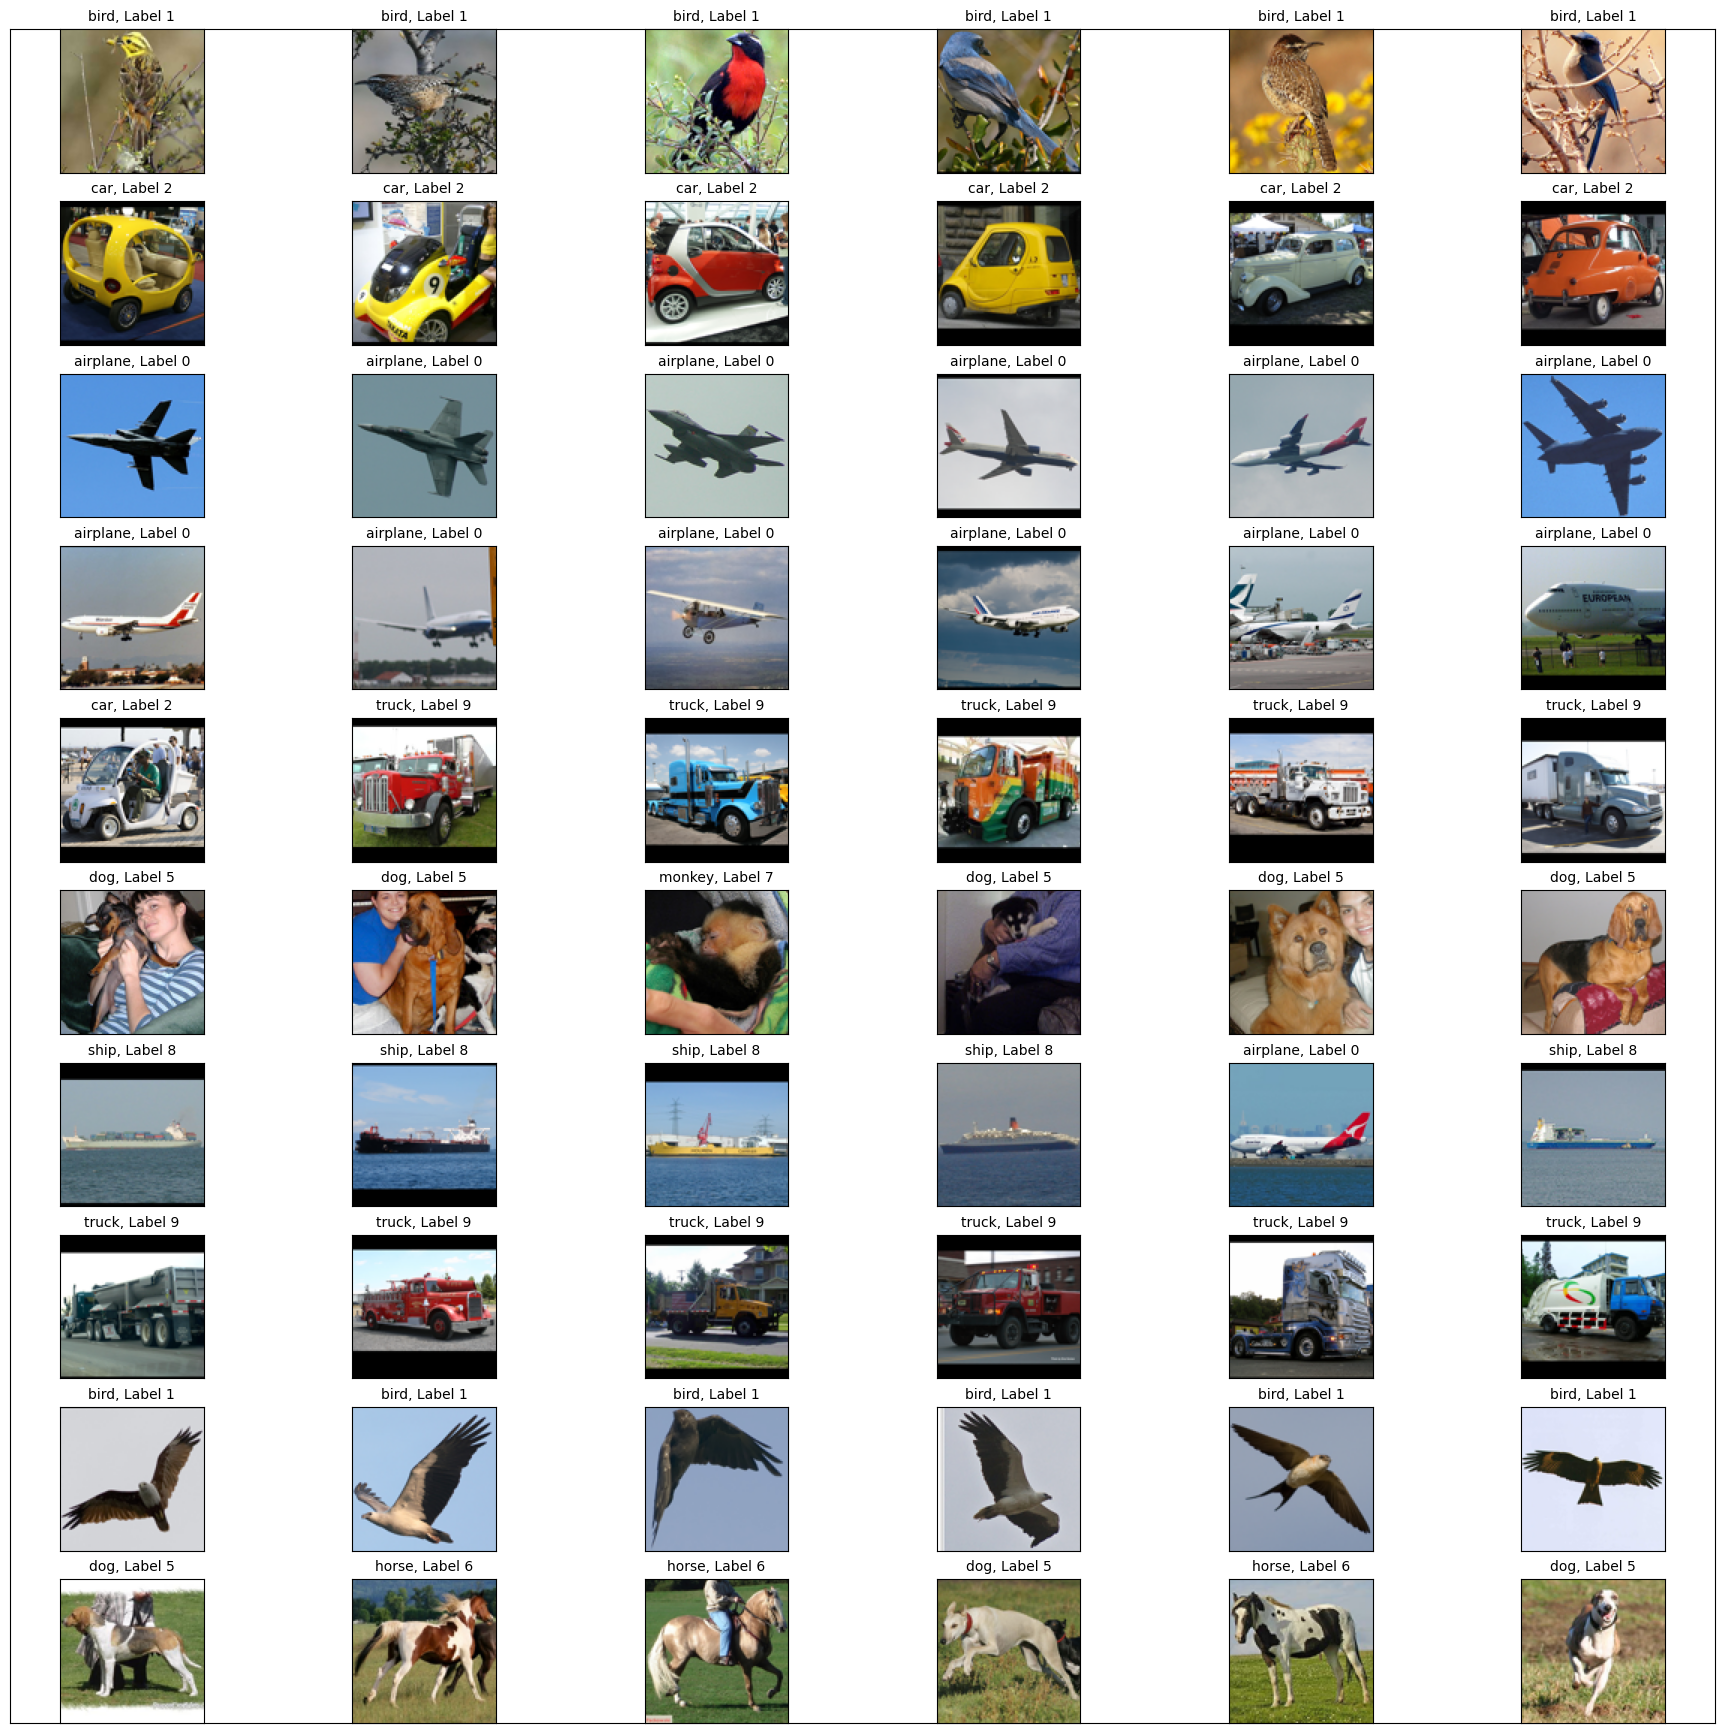

In [67]:
# Provided
class_names = torchvision.datasets.STL10(root='./data').classes
def vizualize_pairs(indices, true_labels, train_ds):
    # Visualize the reference image and its 7 nearest neighbors
    ref_ids = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    nn_viz = 6
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.figure(figsize = (22,22))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for c, ref in enumerate(ref_ids):
        knns = indices[ref, :nn_viz]
        imgs_to_viz = [train_ds[ref][0]]
        true_labels = [train_ds[ref][1]]
        for i in knns:
            imgs_to_viz.append(train_ds[i][0])
            true_labels.append(train_ds[i][1])
        # show the images
        for j in range(nn_viz):
            label = int(true_labels[j])
            plt.subplot(len(ref_ids), nn_viz, (c*nn_viz)+(j+1))
            imshow(imgs_to_viz[j])
            plt.title(f"{class_names[label]}, Label {label}", fontsize = 10)
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    # plt.savefig(f'./figs/knn_viz', bbox_inches = "tight", dpi = 500)

### START CODE HERE ### ( 7-8 line of code)
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=50, metric='cosine')
knn.fit(train_features, train_labels)

indices = knn.kneighbors(train_features, return_distance=False)[:,1:]
vizualize_pairs(indices, train_labels, train_ds=train_loader.dataset)

torch.save(train_features, 'train_feats.pth')
torch.save(indices, 'knn_indices.pth')
### END CODE HERE ###

## Expected result

![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week05/figs/knn_viz.png)

### Task 5: Write a new dataset class to load image pairs

In [74]:

class PairSTL10(torch.utils.data.Dataset):
    def __init__(self, indices_path="./knn_indices.pth", embeds_path="./train_feats.pth", l2_normalize=True):
        ### START CODE HERE ###
        self.indices = torch.from_numpy(torch.load(indices_path))
        self.embeds = torch.from_numpy(torch.load(embeds_path))

        if l2_normalize:
            self.embeds = F.normalize(self.embeds, p=2, dim=1)
        ### END CODE HERE ###

    def __getitem__(self, index):
        ### START CODE HERE ###
        return self.embeds[index], self.embeds[self.indices[index, 0]]
        ### END CODE HERE ###

    def __len__(self):
        ### START CODE HERE ###
        return len(self.embeds)
        ### END CODE HERE ###

def test_get_pair():
    dataset = PairSTL10()
    emb1, emb2 = dataset[16]
    print(emb1.shape, emb2.shape)
    assert emb1.shape==emb2.shape

test_get_pair()

train_loader = torch.utils.data.DataLoader(PairSTL10(), batch_size=128, shuffle=True, num_workers=4)
data_batch = next(iter(train_loader))
print(data_batch[0].shape, data_batch[1].shape)


torch.Size([2048]) torch.Size([2048])
torch.Size([128, 2048]) torch.Size([128, 2048])


## Expected result

```
torch.Size([2048]) torch.Size([2048])
torch.Size([128, 2048]) torch.Size([128, 2048])
```

### Task 6: Implement the SCAN loss. Train the clustering head and compute the validation accuracy.
Paper: https://arxiv.org/abs/2005.12320 (semantic clustering loss)

In [118]:
class SCAN(torch.nn.Module):
    def __init__(self, alpha=1):
        super().__init__()
        self.alpha = alpha

    def forward(self, proj_1, proj_2):
        ### START CODE HERE ### (≈ 5 lines of code)\
        # convert to probability using softmax
        proj_1 = F.softmax(proj_1, dim=1)
        proj_2 = F.softmax(proj_2, dim=1)
        cluster_mean = torch.mean(proj_1, dim=0)
        entropy_loss = torch.sum(cluster_mean*torch.log(cluster_mean))
        dot_product = torch.einsum('ij,ij->i', proj_1, proj_2)
        sim_loss = -torch.mean(torch.log(dot_product))
        ### END CODE HERE ###
        return sim_loss + self.alpha * entropy_loss

def test_scan():
    torch.manual_seed(99)
    scan = SCAN(alpha=1)
    proj_1 = torch.randn(100, 128)
    proj_2 = torch.randn(100, 128)
    loss = scan(proj_1, proj_2)
    print(loss)
    assert loss.shape==torch.Size([])
test_scan()

tensor(0.0275)


### Expected results

For alpha=1, output = `tensor(0.0275)`

### Task 7: Implement the PMI loss. 
Paper: https://arxiv.org/abs/2303.17896 (Section 3, Equation 8)
- Typically methods have multiple clustering heads. We use just one here!

In [146]:
class PMI(torch.nn.Module):
    def __init__(self, gamma=1, momentum=0.99, temp=0.1):
        super().__init__()
        self.gamma = gamma
        self.temp = temp
        self.center  = None
        self.momentum = momentum

    def forward(self, proj_1, proj_2):
        ### START CODE HERE ###
        p1 = (proj_1)/ self.temp
        p1 = torch.exp(p1)/ \
            torch.sum(torch.exp(p1), dim=1, keepdim=True)
        p2 = (proj_2)/ self.temp
        p2 = torch.exp(p2)/ \
            torch.sum(torch.exp(p2), dim=1, keepdim=True)

        self.update_ema(p1)

        pmi_loss = -self.pmi(p1, p2, self.center).mean()
        ### END CODE HERE ###
        return pmi_loss


    def pmi(self, p1, p2, pk):
        ### START CODE HERE ###
        return torch.log(torch.sum(p1 *p2/ (pk + 1e-7), axis=1))
        ### END CODE HERE ###

    @torch.no_grad()
    def update_ema(self, output):
        """
        Update exponential moving average.
        """
        batch_center = output.detach().mean(dim=0)
        if self.center is None:
            # Initialize center uniformly
            self.center = torch.ones_like(batch_center) / batch_center.size(0)
        ### START CODE HERE ### (1 line of code)
        self.center = self.momentum * self.center + \
                        (1 - self.momentum) * batch_center
        ### END CODE HERE ###


def test_pmi():
    torch.manual_seed(99)
    criterion = PMI(gamma=1)
    proj_1 = torch.rand(100, 128)
    proj_2 = torch.rand(100, 128)
    loss = criterion(proj_1, proj_2)
    print(loss)
    assert loss.shape==torch.Size([])

test_pmi()

tensor(0.0737)


### Expected results 

`tensor(0.0738)`

### Task 8: Modify pretraining code

- The previous training code will not work out of the box since now we load image pairs that are nearest neiboughrs in feature space.


In [147]:
import copy

class EMA():
    def __init__(self, alpha, student):
        super().__init__()
        self.alpha = alpha
        self.teacher = copy.deepcopy(student)
        for p in self.teacher.parameters():
            p.requires_grad = False

    def update_average(self, old, new):
        if old is None:
            return new
        ### START CODE HERE ###
        return old.data * self.alpha + new.data * (1 - self.alpha)
        ### END CODE HERE ###

    def update_teacher(self, student):
        for ema_params, student_params in zip(self.teacher.parameters(), student.parameters()):
            old_weight, student_weight = ema_params.data, student_params.data
            ema_params.data = self.update_average(old_weight, student_weight)


def pretrain_one_epoch(model, optimizer, train_loader, criterion, device, model_ema=False):
    """
    Args:
        model_ema (bool, optional): Whether we use  an exponential moving
        average for the second image/view. If false both images/views share the same
        feature extractor. Defaults to False.
    Returns:
        the mean loss of the current epoch
    """
    ### START CODE HERE ### (≈ 12 lines of code)
    model.train()
    loss_step = []
    if model_ema:
        ema = EMA(0.99, model)
    for (proj_1, proj_2) in train_loader:
        proj_1 = proj_1.to(device); proj_2 = proj_2.to(device)
        proj_1 = model(proj_1)
        proj_2 = ema.teacher(proj_2) if model_ema else model(proj_2)
        loss = criterion(proj_1, proj_2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_step.append(loss.item())
        if model_ema:
            ema.update_teacher(model)
    loss_curr_epoch = np.mean(loss_step)
    ### END CODE HERE ###
    return loss_curr_epoch

# This will be given to the students
def pretrain(model, optimizer, num_epochs, train_loader, criterion, device, prefix="scan", model_ema=False):
    dict_log = {"train_loss":[]}
    best_loss = 1e8
    model = model.to(device)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        loss_curr_epoch = pretrain_one_epoch(model, optimizer, train_loader, criterion, device, model_ema=model_ema)
        msg = (f'Ep {epoch}/{num_epochs}: || Loss: Train {loss_curr_epoch:.3f}')
        pbar.set_description(msg)
        dict_log["train_loss"].append(loss_curr_epoch)
        if loss_curr_epoch < best_loss:
            best_loss = loss_curr_epoch
            save_model(model, f'{prefix}_best_model_min_val_loss.pth', epoch, optimizer, best_loss)
    return dict_log

### Task 9: Train with SCAN and PMI using the KNN pairs

Train the clustering head (a small MLP) and compute the validation accuracy for both methods.

In [149]:
dataset = PairSTL10(indices_path="./knn_indices.pth", embeds_path="./train_feats.pth", l2_normalize=True)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
criterion = SCAN(alpha=10)
n_clusters = 10
num_epochs = 150

def get_mlp(n_clusters=10):
    ### START CODE HERE
    return torch.nn.Sequential(
                torch.nn.Linear(2048, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, n_clusters))
    ### END CODE HERE

# SCAN
scan_head = get_mlp(n_clusters=n_clusters)
optimizer = torch.optim.Adam(scan_head.parameters(), lr=1e-4, weight_decay=1e-6)
dict_log_scan = pretrain(scan_head, optimizer, num_epochs, train_loader, criterion, device, prefix="scan")

# PMI
criterion = PMI(gamma=0.65, momentum=0.9, temp=0.1)
pmi_head = get_mlp(n_clusters=n_clusters)
optimizer = torch.optim.Adam(pmi_head.parameters(), lr=1e-4, weight_decay=1e-6)
dict_log_pmi = pretrain(pmi_head, optimizer, num_epochs, train_loader, criterion, device, prefix="pmi", model_ema=True)

Ep 0/150: || Loss: Train -20.726:   1%|          | 1/150 [00:02<05:49,  2.34s/it]


KeyboardInterrupt: 

### Task 10: Get cluster assignments and evaluate cluster accuracy

- The code you need to fill loads the feature and computes the logits (unnormalized output of the trained clustering head)
- For details on how to preprocess the data, you need to mimic the training data pipeline.


In [ ]:
@torch.no_grad()
def evaluate_clustering(model):
    model.eval()
    val_feats, val_labels = torch.load("val_feats.pth"), torch.load("val_labels.pth")
    train_feats, train_labels = torch.load("train_feats.pth"), torch.load("train_labels.pth")

    ### START CODE HERE
    train_feats = F.normalize(train_feats, dim=-1, p=2)
    val_feats = F.normalize(val_feats, dim=-1, p=2)
    train_dataset = torch.utils.data.TensorDataset(train_feats, train_labels)
    val_dataset = torch.utils.data.TensorDataset(val_feats, val_labels)

    train_feat_dl = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False)
    val_feat_dl = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)
    train_logits, _ = get_features(model, train_feat_dl, device)
    val_logits, _ = get_features(model, val_feat_dl, device)
    ### END CODE HERE


    train_preds = train_logits.argmax(dim=-1).cpu().numpy()
    val_preds =val_logits.argmax(dim=-1).cpu().numpy()
    print("Unique preds", np.unique(train_preds), np.unique(val_preds))
    #assert len(np.unique(train_preds)) == n_clusters , "Collapse! Number of predicted assignments is not equal to number of clusters"

    metrics_train = compute_clustering_metrics(train_labels.cpu().numpy(), train_preds, min_samples_per_class=10)
    metrics_val = compute_clustering_metrics(val_labels.cpu().numpy(), val_preds,min_samples_per_class=10)
    return metrics_train[0], metrics_val[0]

n_clusters = 10
model = get_mlp(n_clusters=n_clusters)
model_scan = load_model(model, "./scan_best_model_min_val_loss.pth")

model = get_mlp(n_clusters=n_clusters)
model_pmi = load_model(model, "./pmi_best_model_min_val_loss.pth")
train_acc, val_acc = evaluate_clustering(model_scan)
print(f"SCAN: Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")
train_acc, val_acc = evaluate_clustering(model_pmi)
print(f"PMI: Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

### Expected results:
Current best scores!
```
Model ./scan_best_model_min_val_loss.pth is loaded from epoch 148 , loss -22.383880043029784
Model ./pmi_best_model_min_val_loss.pth is loaded from epoch 129 , loss -2.0719790697097777
Unique preds [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
SCAN: Train acc: 74.380, Val acc: 74.450
Unique preds [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
PMI: Train acc: 77.280, Val acc: 78.238
```

# Conclusion 

That's the end of this exercise. If you reached this point, congratulations!
